<a href="https://colab.research.google.com/github/LeoVogiatzis/GNN_based_NILM/blob/main/main/notebooks/Nilm_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install pandas
# !pip install networkx
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-1.9.0+cu111.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-1.9.0+cu111.html
# !pip install torch-geometric
# !pip install torch
# Install required packages.
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


     |████████████████████████████████| 7.9 MB 4.4 MB/s 
     |████████████████████████████████| 3.5 MB 4.4 MB/s 
     |████████████████████████████████| 407 kB 4.2 MB/s 
     |████████████████████████████████| 45 kB 3.1 MB/s 


In [2]:
# !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-geometric
import networkx as nx
import pandas as pd
import torch
import torch_geometric
from torch_geometric.data import Dataset, Data
import numpy as np
import os
from tqdm import tqdm

In [3]:
print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")
print(f"Torch geometric version: {torch_geometric.__version__}")


Torch version: 1.10.0+cu111
Cuda available: True
Torch geometric version: 2.0.2


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [48]:
class NilmDataset(Dataset):
    def __init__(self, root, filename, test=False, transform=None, pre_transform=None):
        """2
        root = Where the dataset should be stored. This folder is split 
        into raw_dir (downloaded dataset) and processed_dir (processed data).
        """
        self.test = test
        self.filename = filename
        super(NilmDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)
        """
        return self.filename

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]

    def download(self):
        pass

    def process(self):
        self.G = nx.read_graphml(self.raw_paths[0])
        print(len(self.G.nodes), len(self.G.edges))
        # TODO: read graphs below
            # Get node features
        node_feats = self._get_node_features(self.G)
            # Get edge features
        edge_feats = self._get_edge_features(self.G)
            # Get adjacency info
        edge_index = self._get_adjacency_info(self.G)
            # Get labels info
        labels = self._get_labels(nx.get_node_attributes(self.G, 'state'))  # pass label here. E.g. if it is a column for this graph it could be graph_csv['label']

            # Create data object
        # self.data = Data(x=node_feats, edge_index=edge_index, y=labels)
        self.data = Data(x=node_feats, edge_index=edge_index, edge_attr=edge_feats, y=labels)

        self.data.num_classes = 2

        # splitting the data into train, validation and test
        X_train, X_test, y_train, y_test = train_test_split(pd.Series(np.asarray([int(i) for i in self.G.nodes()]).astype(np.int64)), 
                                                            pd.Series(labels),
                                                            test_size=0.30, 
                                                            random_state=42)
        
        n_nodes = self.G.number_of_nodes()
        
        # create train and test masks for data
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[X_train.index] = True
        test_mask[X_test.index] = True
        self.data['train_mask'] = train_mask
        self.data['test_mask'] = test_mask

        # self.data, self.slices = self.collate([data])


        if self.test:
          torch.save(self.data, os.path.join(self.processed_dir, 'data_test_0.pt'))
        else:
          torch.save(self.data, os.path.join(self.processed_dir, 'data_0.pt'))

    def _get_node_features(self, graph):
        """
        This will return a matrix / 2d array of the shape
        [Number of Nodes, Node Feature size]

        We could also use torch_geometric.from_networkx to create a Data object
        with both adjacency and features, but instead we do it manually here
        """
        all_node_feats = list(nx.get_node_attributes(graph, 'drift').values())

        all_node_feats = np.asarray(all_node_feats)
        all_node_feats = all_node_feats.reshape((-1, 1))
        return torch.tensor(all_node_feats, dtype=torch.float)

    def _get_edge_features(self, graph):
      """
        This will return a matirx with the gaussian filter kernel of all 
        edges
      """
      all_edge_feats = []
      for e in graph.edges(data=True):
        all_edge_feats += [[e[2]['gaussian_kernel']], [e[2]['gaussian_kernel']]]

      return torch.tensor(all_edge_feats, dtype=torch.float)

    def _get_adjacency_info(self, graph):
        """
        We could also use torch_geometric.from_networkx to create a Data object
        with both adjacency and features, but instead we do it manually here
        """

        edge_indices = []
        for edge in graph.edges:
            i = int(edge[0])  # get source
            j = int(edge[1])  # get destination
            edge_indices += [[i, j], [j, i]]  # undirected graph

        edge_indices = torch.tensor(edge_indices)
        edge_indices = edge_indices.t().to(torch.long).view(2, -1)
        return edge_indices

    def _get_labels(self, labels):
        labels = list(labels.values())
        labels = np.asarray(labels)
        return torch.tensor(labels, dtype=torch.int64)

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'))
        return data

In [83]:
data = NilmDataset(root='data', filename='dishwaser_20.graphml')
print(data.data)

Processing...


410 41820
Data(x=[410, 1], edge_index=[2, 83640], edge_attr=[83640, 1], y=[410], num_classes=2, train_mask=[410], test_mask=[410])


Done!


In [ ]:
data.data.train_mask

In [77]:
data = g
print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# print(f'Number of training nodes: {data.train_mask.sum()}')
# print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(edge_index=[2, 83640], Timestamp=[410], state=[410], drift=[410], gaussian_kernel=[83640], num_nodes=410)
Number of nodes: 410
Number of edges: 83640
Average node degree: 204.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Data(edge_index=[2, 83640], Timestamp=[410], state=[410], drift=[410], gaussian_kernel=[83640], num_nodes=410)

In [51]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

edge_index = g.edge_index
print(edge_index.t())

<IPython.core.display.Javascript object>

tensor([[  0,   1],
        [  0,   2],
        [  0,   3],
        ...,
        [409, 406],
        [409, 407],
        [409, 408]])


In [52]:
import matplotlib.pyplot as plt

def visualize(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

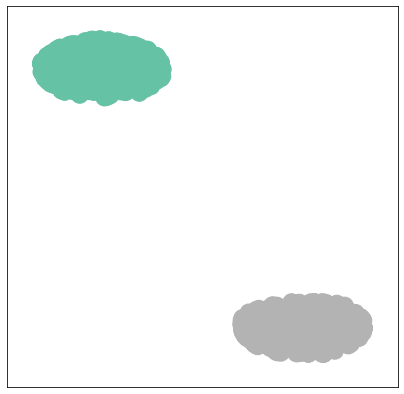

In [56]:
visualize(G, color=data.data.
          y)

In [28]:
data.state

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [81]:
data.data.num_classes

AttributeError: ignored

In [84]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self,hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # Initialize the layers
        self.conv1 = GCNConv(data.data.num_features, data.data.num_features)
        self.conv2 = GCNConv(data.data.num_features, data.data.num_features)
        self.out = Linear(hidden_channels, data.data.num_classes)

    def forward(self, x, edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Output layer 
        x = F.softmax(self.out(x), dim=1)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1, 1)
  (conv2): GCNConv(1, 1)
  (out): Linear(in_features=16, out_features=2, bias=True)
)


In [91]:
print(len(data.data.edge_index))
print(len(data.data.x))

2
410


In [93]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

# loss = criterion(out[data.train_mask], data.y[data.train_mask])

model = GCN(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.data.x, edge_index=data.data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(401):
    loss, h = train(data)
    if epoch % 10 == 0:
        visualize(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)

<IPython.core.display.Javascript object>

RuntimeError: ignored